# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [1]:
import pandas as pd
import numpy as np
import math
import json
import operator

#import custom method.py file 
import methods as m

# reload to make sure we have the latest version of method.py loaded
import importlib
importlib.reload(m)

#seaborn plot for visualization
import seaborn as sns
sns.set(style="darkgrid")
import matplotlib as mpl
import matplotlib.pyplot as plt

# Suppress warnings for seaborn and pandas SettingwithCopy warnings 
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None 

# library imports for modelling and prediction
from sklearn import metrics
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV

! pip install xgboost

import xgboost as xgb

% matplotlib inline

    100% |████████████████████████████████| 109.8MB 331kB/s eta 0:00:010% |                                | 102kB 3.2MB/s eta 0:00:35    0% |▏                               | 614kB 12.2MB/s eta 0:00:09    3% |█▏                              | 4.0MB 29.9MB/s eta 0:00:04    4% |█▋                              | 5.4MB 27.7MB/s eta 0:00:04    10% |███▎                            | 11.3MB 26.3MB/s eta 0:00:04    16% |█████▍                          | 18.6MB 27.4MB/s eta 0:00:04    19% |██████▎                         | 21.4MB 31.5MB/s eta 0:00:03    27% |████████▊                       | 29.7MB 30.8MB/s eta 0:00:03    28% |█████████                       | 31.2MB 29.6MB/s eta 0:00:03    32% |██████████▎                     | 35.3MB 29.6MB/s eta 0:00:03    34% |███████████                     | 37.9MB 25.7MB/s eta 0:00:03    38% |████████████▎                   | 41.9MB 30.0MB/s eta 0:00:03    49% |███████████████▉                | 54.5MB 24.1MB/s eta 0:00:03    51% |████████████████▋      

In [2]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## 1. Explore each dataframe 

### I. Portfolio data

In [3]:
# details of the offers
# portfolio.json

'''
id (string) - offer id
offer_type (string) - type of offer ie BOGO, discount, informational
difficulty (int) - minimum required spend to complete an offer
reward (int) - reward given for completing an offer
duration (int) - time for offer to be open, in days
channels (list of strings)
'''

portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [4]:
# explore portfolio dataframe
# this is using a method saved in methods.py file

m.explore_df(portfolio)

The dataframe has  10 rows and  6 columns 

There are  3 categorical columns and  3 numerical columns in the dataframe 

A list of all the categorical columns 

['channels', 'id', 'offer_type'] 

Unique values in column  channels : [['email', 'mobile', 'social'], ['web', 'email'], ['web', 'email', 'mobile'], ['web', 'email', 'mobile', 'social']] 

Unique values in column  id : ['0b1e1539f2cc45b7b9fa7c272da2e1d7', '2298d6c36e964ae4a3e7e9706d1fb8c2', '2906b810c7d4411798c6938adc9daaa5', '3f207df678b143eea3cee63160fa8bed', '4d5c57ea9a6940dd891ad53e9dbe8da0', '5a8bc65990b245e5a138643cd4eb9837', '9b98b8c7a33c4b65b9aebfe6a799e6d9', 'ae264e3637204a6fb9bb56bc8210ddfd', 'f19421c1d4aa40978ebb69ca19b0e20d', 'fafdcd668e3743c1bb461111dcafc2a4'] 

Unique values in column  offer_type : ['bogo', 'discount', 'informational'] 


 A list of all the numerical columns 

['difficulty', 'duration', 'reward'] 

Statistical details for the numerical columns 
        difficulty   duration     reward
count   10.0

In [5]:
portfolio['offer_type'].value_counts()

bogo             4
discount         4
informational    2
Name: offer_type, dtype: int64


### General observations
1. we have 10 different offers available in our data set. and overall the rewards vary between 0 and 10 usd 
2. The offer types are bogo, discount and informational
3. The channel values are email, mobile, social and web

We need to work on 
1. mapping the offer ids to unique offer id numerical values
2. converting channels column in a way where its hot encoded to include all the channels in that list on a single row
        i.e. ['email','social'] should be converted to columns 'email' and 'social' with a value of 1
3. The offer type needs to be one hot encoded

In [6]:
# explore null values in portfolio dataframe
m.explore_null(portfolio)

The column(s) with all null values:  set() 

 More than  25 % of values are null for columns  set() 

 More than  50 % of values are null for columns  set() 

 More than  75 % of values are null for columns  set() 



This is good news. There are no columns in portfolio with all null values

### II. Profile data

In [7]:
# we are exploring the customer profiles next
'''
age (int) - age of the customer
became_member_on (int) - date when customer created an app account
gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
id (str) - customer id
income (float) - customer's income
'''
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [8]:
# explore profile dataframe
profile['gender'] = profile['gender'].astype(str)

m.explore_df(profile)

The dataframe has  17000 rows and  5 columns 

There are  2 categorical columns and  3 numerical columns in the dataframe 

A list of all the categorical columns 

['gender', 'id'] 

Unique values in column  gender : ['F', 'M', 'None', 'O'] 

Total number of unique values for column  id is  17000 

The first 10 unique values are ['0009655768c64bdeb2e877511632db8f', '00116118485d4dfda04fdbaba9a87b5c', '0011e0d4e6b944f998e987f904e8c1e5', '0020c2b971eb4e9188eac86d93036a77', '0020ccbbb6d84e358d3414a3ff76cffd', '003d66b6608740288d6cc97a6903f4f0', '00426fe3ffde4c6b9cb9ad6d077a13ea', '004b041fbfe44859945daa2c7f79ee64', '004c5799adbf42868b9cff0396190900', '005500a7188546ff8a767329a2f7c76a']

 A list of all the numerical columns 

['age', 'became_member_on', 'income'] 

Statistical details for the numerical columns 
                 age  became_member_on         income
count  17000.000000      1.700000e+04   14825.000000
mean      62.531412      2.016703e+07   65404.991568
std       26.738580  

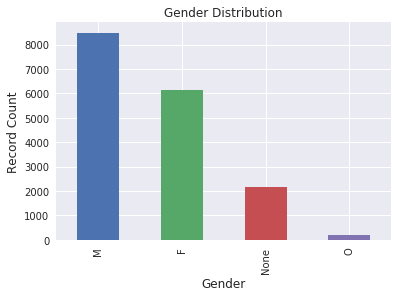

In [9]:
# plot no of records for each gender type
profile['gender'].value_counts().plot(kind='bar')

plt.title('Gender Distribution')
plt.ylabel('Record Count', fontsize=12)
plt.xlabel('Gender', fontsize=12)
plt.show()

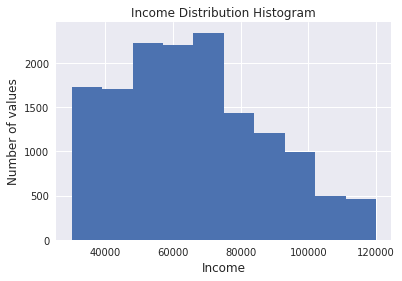

In [10]:
# plot a histogram for income 
profile['income'].hist()

plt.title('Income Distribution Histogram')
plt.ylabel('Number of values', fontsize=12)
plt.xlabel('Income', fontsize=12)
plt.show()

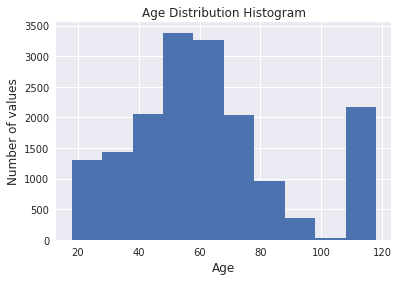

In [11]:
# plot a histogram for income 
profile['age'].hist()

plt.title('Age Distribution Histogram')
plt.ylabel('Number of values', fontsize=12)
plt.xlabel('Age', fontsize=12)
plt.show()

### General observations
1. There are 17000 customer ids in the data set

 we need to work on

1. The became_member_on field should be converted into a date object from a numerical column
2. The age column has a max value of 118 which feels a little out of the place
3. mapping the customer id to numerical values
4. one hot encode the gender column

In [12]:
# explore nulls in profile dataframe
m.explore_null(profile)

The column(s) with all null values:  set() 

 More than  25 % of values are null for columns  set() 

 More than  50 % of values are null for columns  set() 

 More than  75 % of values are null for columns  set() 



This is good news. There are no columns in profile with all null values

### III. Transcript/Transaction data

In [13]:
# explore the transcript dataframe next which keeps record of the transactions/events
'''
event (str) - record description (ie transaction, offer received, offer viewed, etc.)
person (str) - customer id
time (int) - time in hours since start of test. The data begins at time t=0
value - (dict of strings) - either an offer id or transaction amount depending on the record
'''
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [14]:
m.explore_df(transcript)

The dataframe has  306534 rows and  4 columns 

There are  3 categorical columns and  1 numerical columns in the dataframe 

A list of all the categorical columns 

['event', 'person', 'value'] 

Unique values in column  event : ['offer completed', 'offer received', 'offer viewed', 'transaction'] 

Total number of unique values for column  person is  17000 

The first 10 unique values are ['0009655768c64bdeb2e877511632db8f', '00116118485d4dfda04fdbaba9a87b5c', '0011e0d4e6b944f998e987f904e8c1e5', '0020c2b971eb4e9188eac86d93036a77', '0020ccbbb6d84e358d3414a3ff76cffd', '003d66b6608740288d6cc97a6903f4f0', '00426fe3ffde4c6b9cb9ad6d077a13ea', '004b041fbfe44859945daa2c7f79ee64', '004c5799adbf42868b9cff0396190900', '005500a7188546ff8a767329a2f7c76a']

 A list of all the numerical columns 

['time'] 

Statistical details for the numerical columns 
                 time
count  306534.000000
mean      366.382940
std       200.326314
min         0.000000
25%       186.000000
50%       408.000000
7

### General Observations
1. Offers fall into one of the categories ['offer completed', 'offer received', 'offer viewed', 'transaction'] 


We need to work to
1. convert time column into a date time column type
2. convert value column into a numerical column and one hot encode based on the key,value pair
3. map the person to customer id
4. event column to be one hot encoded

## 2. Data Cleaning

We will now work on all the "need to work" sections we discussed above for each dataset

### I. Portfolio


We need to work on 
1. mapping the offer ids to unique offer id numerical values
2. converting channels column in a way where its hot encoded to include all the channels in that list on a single row
        i.e. ['email','social'] should be converted to columns 'email' and 'social' with a value of 1
3. The offer type needs to be one hot encoded

In [15]:
# map the portfolio ids into numerical value and store in a dict
port_id_dict = m.map_ids(portfolio,'id')

# create a new id column in the dataframe based on above dictionary
portfolio['offer_id'] =  portfolio['id'].apply(lambda x: port_id_dict[x])

# drop original column
portfolio = portfolio.drop(['id'],axis=1)

portfolio.head()

,channels,difficulty,duration,offer_type,reward,offer_id
0,"[email, mobile, social]",10,7,bogo,10,0
1,"[web, email, mobile, social]",10,5,bogo,10,1
2,"[web, email, mobile]",0,4,informational,0,2
3,"[web, email, mobile]",5,7,bogo,5,3
4,"[web, email]",20,10,discount,5,4


In [16]:
# we need to one hot encode the channels column to separate out the values
portfolio = m.one_hot_encode_for_lists(portfolio,'channels')          
portfolio.head()

,difficulty,duration,offer_type,reward,offer_id,email,social,mobile,web
0,10,7,bogo,10,0,1.0,1.0,1.0,0.0
1,10,5,bogo,10,1,1.0,1.0,1.0,1.0
2,0,4,informational,0,2,1.0,0.0,1.0,1.0
3,5,7,bogo,5,3,1.0,0.0,1.0,1.0
4,20,10,discount,5,4,1.0,0.0,0.0,1.0


In [17]:
# we now one hot encode all columns which will separate out the offer type column
portfolio = m.one_hot_encode(portfolio)
portfolio

,difficulty,duration,reward,offer_id,email,social,mobile,web,offer_type_bogo,offer_type_discount,offer_type_informational
0,10,7,10,0,1.0,1.0,1.0,0.0,1,0,0
1,10,5,10,1,1.0,1.0,1.0,1.0,1,0,0
2,0,4,0,2,1.0,0.0,1.0,1.0,0,0,1
3,5,7,5,3,1.0,0.0,1.0,1.0,1,0,0
4,20,10,5,4,1.0,0.0,0.0,1.0,0,1,0
5,7,7,3,5,1.0,1.0,1.0,1.0,0,1,0
6,10,10,2,6,1.0,1.0,1.0,1.0,0,1,0
7,0,3,0,7,1.0,1.0,1.0,0.0,0,0,1
8,5,5,5,8,1.0,1.0,1.0,1.0,1,0,0
9,10,7,2,9,1.0,0.0,1.0,1.0,0,1,0


### II. Profile

 we need to work on

1. mapping the customer id to numerical values
2. one hot encode the gender column
3. The became_member_on field should be converted into a date object from a numerical column
4. The age column has a max value of 118 which feels a little out of the place

In [18]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [19]:
# map the portfolio ids into numerical value and store in a dict
profile_id_dict = m.map_ids(profile,'id')

# create a new id column in the dataframe based on above dictionary
profile['customer_id'] =  profile['id'].apply(lambda x: profile_id_dict[x])

# drop original column
profile = profile.drop(['id'],axis=1)

profile.head()

,age,became_member_on,gender,income,customer_id
0,118,20170212,None,NaN,0
1,55,20170715,F,112000.0,1
2,118,20180712,None,NaN,2
3,75,20170509,F,100000.0,3
4,118,20170804,None,NaN,4


In [20]:
profile.dtypes

age                   int64
became_member_on      int64
gender               object
income              float64
customer_id           int64
dtype: object

In [21]:
# one hot encode profile dataframe
profile = m.one_hot_encode(profile)
profile.head()

,age,became_member_on,income,customer_id,gender_F,gender_M,gender_None,gender_O
0,118,20170212,NaN,0,0,0,1,0
1,55,20170715,112000.0,1,1,0,0,0
2,118,20180712,NaN,2,0,0,1,0
3,75,20170509,100000.0,3,1,0,0,0
4,118,20170804,NaN,4,0,0,1,0


In [22]:
# change data type for 'became member on' fields to a date type
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'].astype(str), format='%Y%m%d')
profile.head()

,age,became_member_on,income,customer_id,gender_F,gender_M,gender_None,gender_O
0,118,2017-02-12,NaN,0,0,0,1,0
1,55,2017-07-15,112000.0,1,1,0,0,0
2,118,2018-07-12,NaN,2,0,0,1,0
3,75,2017-05-09,100000.0,3,1,0,0,0
4,118,2017-08-04,NaN,4,0,0,1,0


In [23]:
profile['gender_None'].value_counts()

0    14825
1     2175
Name: gender_None, dtype: int64

Around 2175 rows have no gender information in the data set

In [24]:
# check the details of rows where gender is "None"
profile[profile['gender_None']==1].describe()

,age,income,customer_id,gender_F,gender_M,gender_None,gender_O
count,2175.0,0.0,2175.000000,2175.0,2175.0,2175.0,2175.0
mean,118.0,NaN,8516.805517,0.0,0.0,1.0,0.0
std,0.0,NaN,4985.473324,0.0,0.0,0.0,0.0
min,118.0,NaN,0.000000,0.0,0.0,1.0,0.0
25%,118.0,NaN,4005.500000,0.0,0.0,1.0,0.0
50%,118.0,NaN,8541.000000,0.0,0.0,1.0,0.0
75%,118.0,NaN,12854.000000,0.0,0.0,1.0,0.0
max,118.0,NaN,16994.000000,0.0,0.0,1.0,0.0


In [25]:
profile[profile['gender_None']==1]['age'].value_counts()

118    2175
Name: age, dtype: int64

In [26]:
# check how many income values in rows are null
profile['income'].isnull().value_counts()

False    14825
True      2175
Name: income, dtype: int64

From the above two checks all the rows with no gender information i.e. gender_None=1 , the age value for all rows is set as 118 and income is set to null . This essentially means we can ignore all the rows with age set to 118 to help us retrieve a clean and meaningful dataset 

In [27]:
print("Percent of Null values in income column",round((profile['income'].isnull().mean()*100),2),"%")

Percent of Null values in income column 12.79 %


In [28]:
# we exclude values for age 118 as they are essentially bad data
profile = profile[profile['age']!=118]
# drop gender_None column
profile =  profile.drop(['gender_None'],axis=1)
profile.head()

,age,became_member_on,income,customer_id,gender_F,gender_M,gender_O
1,55,2017-07-15,112000.0,1,1,0,0
3,75,2017-05-09,100000.0,3,1,0,0
5,68,2018-04-26,70000.0,5,0,1,0
8,65,2018-02-09,53000.0,8,0,1,0
12,58,2017-11-11,51000.0,12,0,1,0


### III. Transcript/Transaction data

We need to work to

1. map the person to customer id
2. event column to be one hot encoded
3. convert value column into a numerical column and one hot encode based on the key,value pair

In [29]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [30]:
# create a new id column in the dataframe based on above dictionary
transcript['customer_id'] =  transcript['person'].apply(lambda x: profile_id_dict[x])

# drop original column
transcript = transcript.drop(['person'],axis=1)

transcript.head()

,event,time,value,customer_id
0,offer received,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},3
1,offer received,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},4
2,offer received,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},5
3,offer received,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},6
4,offer received,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},7


In [31]:
transcript.dtypes

event          object
time            int64
value          object
customer_id     int64
dtype: object

In [32]:
# values that 'event' column takes
transcript['event'].unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'], dtype=object)

In [33]:
transcript[transcript['event']=="offer completed"].head()

,event,time,value,customer_id
12658,offer completed,0,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...,55
12672,offer completed,0,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,151
12679,offer completed,0,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,174
12692,offer completed,0,{'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd...,299
12697,offer completed,0,{'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0...,316


In [34]:
port_id_dict

{'ae264e3637204a6fb9bb56bc8210ddfd': 0,
 '4d5c57ea9a6940dd891ad53e9dbe8da0': 1,
 '3f207df678b143eea3cee63160fa8bed': 2,
 '9b98b8c7a33c4b65b9aebfe6a799e6d9': 3,
 '0b1e1539f2cc45b7b9fa7c272da2e1d7': 4,
 '2298d6c36e964ae4a3e7e9706d1fb8c2': 5,
 'fafdcd668e3743c1bb461111dcafc2a4': 6,
 '5a8bc65990b245e5a138643cd4eb9837': 7,
 'f19421c1d4aa40978ebb69ca19b0e20d': 8,
 '2906b810c7d4411798c6938adc9daaa5': 9}

In [35]:
# we separate out the 'txn type' and 'txn_value' for offers and amount transacations
# the txn_type for offers will be 'offer_id' and 'amount' for transactions
transcript['txn_type'] = transcript['value'].apply(lambda x: list(x.keys())[0])
transcript['txn_value'] = transcript['value'].apply(lambda x: list(x.values())[0])

transcript.head()

,event,time,value,customer_id,txn_type,txn_value
0,offer received,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},3,offer id,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,offer received,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},4,offer id,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,offer received,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},5,offer id,2906b810c7d4411798c6938adc9daaa5
3,offer received,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},6,offer id,fafdcd668e3743c1bb461111dcafc2a4
4,offer received,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},7,offer id,4d5c57ea9a6940dd891ad53e9dbe8da0


In [36]:
# drop the value column
transcript.drop(['value'],axis=1,inplace=True)

In [37]:
transcript['txn_type'].unique()

array(['offer id', 'amount', 'offer_id'], dtype=object)

In [38]:
# making sure the txn_type value for offer id is consistent i.e. offer_id
transcript['txn_type'] = transcript['txn_type'].apply(lambda x : "offer_id" if x=="offer id" else x)

# we assign the txn_value based on the portfolio dictionary from our initial data cleaning process
# to have the offer ids in txn_value column
transcript['txn_value'] = transcript['txn_value'].apply(lambda x : port_id_dict[x] if x in port_id_dict else x)

transcript.head()

,event,time,customer_id,txn_type,txn_value
0,offer received,0,3,offer_id,3.0
1,offer received,0,4,offer_id,4.0
2,offer received,0,5,offer_id,9.0
3,offer received,0,6,offer_id,6.0
4,offer received,0,7,offer_id,1.0


# Merging all three dataframes to create a single de-duplicated database to analyze

In [39]:
# Merge 1
df_combine1= transcript.merge(profile,on='customer_id')
df_combine1.head()

,event,time,customer_id,txn_type,txn_value,age,became_member_on,income,gender_F,gender_M,gender_O
0,offer received,0,3,offer_id,3.00,75,2017-05-09,100000.0,1,0,0
1,offer viewed,6,3,offer_id,3.00,75,2017-05-09,100000.0,1,0,0
2,transaction,132,3,amount,19.89,75,2017-05-09,100000.0,1,0,0
3,offer completed,132,3,offer_id,3.00,75,2017-05-09,100000.0,1,0,0
4,transaction,144,3,amount,17.78,75,2017-05-09,100000.0,1,0,0


In [40]:
# will help us merge dataframes, to distinguish between offers and amounts in transaction data
portfolio['txn_type'] = 'offer_id'
portfolio.head()

,difficulty,duration,reward,offer_id,email,social,mobile,web,offer_type_bogo,offer_type_discount,offer_type_informational,txn_type
0,10,7,10,0,1.0,1.0,1.0,0.0,1,0,0,offer_id
1,10,5,10,1,1.0,1.0,1.0,1.0,1,0,0,offer_id
2,0,4,0,2,1.0,0.0,1.0,1.0,0,0,1,offer_id
3,5,7,5,3,1.0,0.0,1.0,1.0,1,0,0,offer_id
4,20,10,5,4,1.0,0.0,0.0,1.0,0,1,0,offer_id


In [41]:
# Merge 2
df_combine2 = df_combine1.merge(portfolio, how='left', left_on=['txn_type','txn_value'], right_on=['txn_type','offer_id'])
df_combine2.head()

/opt/conda/lib/python3.6/site-packages/pandas/core/reshape/merge.py:963: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  'representation', UserWarning)


,event,time,customer_id,txn_type,txn_value,age,became_member_on,income,gender_F,gender_M,...,duration,reward,offer_id,email,social,mobile,web,offer_type_bogo,offer_type_discount,offer_type_informational
0,offer received,0,3,offer_id,3.00,75,2017-05-09,100000.0,1,0,...,7.0,5.0,3.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0
1,offer viewed,6,3,offer_id,3.00,75,2017-05-09,100000.0,1,0,...,7.0,5.0,3.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0
2,transaction,132,3,amount,19.89,75,2017-05-09,100000.0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,offer completed,132,3,offer_id,3.00,75,2017-05-09,100000.0,1,0,...,7.0,5.0,3.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0
4,transaction,144,3,amount,17.78,75,2017-05-09,100000.0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [42]:
# doing this to help us one hot encode the event values later and have _ for their names
df_combine2['event'] = df_combine2['event'].apply(lambda x: "_".join(x.split()))

In [43]:
# This gives us the final transaction de-duped data that has the details of each transaction
# the corresponding customer details and the offer details laid out
df_final= m.one_hot_encode(df_combine2)

df_final.head()

,time,customer_id,txn_value,age,became_member_on,income,gender_F,gender_M,gender_O,difficulty,...,web,offer_type_bogo,offer_type_discount,offer_type_informational,event_offer_completed,event_offer_received,event_offer_viewed,event_transaction,txn_type_amount,txn_type_offer_id
0,0,3,3.00,75,2017-05-09,100000.0,1,0,0,5.0,...,1.0,1.0,0.0,0.0,0,1,0,0,0,1
1,6,3,3.00,75,2017-05-09,100000.0,1,0,0,5.0,...,1.0,1.0,0.0,0.0,0,0,1,0,0,1
2,132,3,19.89,75,2017-05-09,100000.0,1,0,0,NaN,...,NaN,NaN,NaN,NaN,0,0,0,1,1,0
3,132,3,3.00,75,2017-05-09,100000.0,1,0,0,5.0,...,1.0,1.0,0.0,0.0,1,0,0,0,0,1
4,144,3,17.78,75,2017-05-09,100000.0,1,0,0,NaN,...,NaN,NaN,NaN,NaN,0,0,0,1,1,0


## Analyzing the transaction for insights

### Insight 1 : Targeting/Recommending offers based on age groups of the customer

We are now going to work on looking at the Age of customers who "completed" an offer and "what" offer did they prefer amongst the ones in the portfolio data

In [44]:
# filter dataframe to only keep offer data and exclude any "amount" transactions
df_only_offers = df_final.query('txn_type_offer_id== 1')
df_only_offers.shape

(148805, 26)

In [45]:
df_only_offers.head()

,time,customer_id,txn_value,age,became_member_on,income,gender_F,gender_M,gender_O,difficulty,...,web,offer_type_bogo,offer_type_discount,offer_type_informational,event_offer_completed,event_offer_received,event_offer_viewed,event_transaction,txn_type_amount,txn_type_offer_id
0,0,3,3.0,75,2017-05-09,100000.0,1,0,0,5.0,...,1.0,1.0,0.0,0.0,0,1,0,0,0,1
1,6,3,3.0,75,2017-05-09,100000.0,1,0,0,5.0,...,1.0,1.0,0.0,0.0,0,0,1,0,0,1
3,132,3,3.0,75,2017-05-09,100000.0,1,0,0,5.0,...,1.0,1.0,0.0,0.0,1,0,0,0,0,1
5,168,3,7.0,75,2017-05-09,100000.0,1,0,0,0.0,...,0.0,0.0,0.0,1.0,0,1,0,0,0,1
6,216,3,7.0,75,2017-05-09,100000.0,1,0,0,0.0,...,0.0,0.0,0.0,1.0,0,0,1,0,0,1


In [46]:
# lets only look at the age of customers and how they received, viewed and completed the offers

df_age_offer_completed = df_only_offers[['age','offer_id','event_offer_completed','event_offer_received','event_offer_viewed']]
# lets breakup the ages into age groups as per the decades i.e. 40s, 50s , 60s etc.
df_age_offer_completed['age_range']= df_age_offer_completed['age'].apply(lambda x: int(x/10)*10)
df_age_offer_completed.head()

,age,offer_id,event_offer_completed,event_offer_received,event_offer_viewed,age_range
0,75,3.0,0,1,0,70
1,75,3.0,0,0,1,70
3,75,3.0,1,0,0,70
5,75,7.0,0,1,0,70
6,75,7.0,0,0,1,70


In [47]:
dff1 = df_age_offer_completed.groupby(['age_range','offer_id'],as_index=False)['event_offer_received','event_offer_viewed','event_offer_completed'].mean()
dff1.head()

,age_range,offer_id,event_offer_received,event_offer_viewed,event_offer_completed
0,10,0.0,0.427861,0.407960,0.164179
1,10,1.0,0.456140,0.438596,0.105263
2,10,2.0,0.720930,0.279070,0.000000
3,10,3.0,0.562500,0.181250,0.256250
4,10,4.0,0.638655,0.100840,0.260504


In [48]:
# Credits stack overflow: https://stackoverflow.com/questions/45161355/pandas-dataframe-find-the-max-after-groupby-two-columns-and-get-counts

# we need to look at the offer ids for each group which had the highest mean value of offer completion
dff2 = dff1.groupby(['age_range']).apply(lambda x: x.offer_id[x.event_offer_completed.idxmax()])
# convert the series into a dataframe
dff2 = pd.DataFrame(dff2).reset_index()
# assign column name to the max completed offer
dff2.rename(columns = {0:'max_offer_id'}, inplace = True) 

dff2

,age_range,max_offer_id
0,10,5.0
1,20,3.0
2,30,3.0
3,40,3.0
4,50,3.0
5,60,9.0
6,70,3.0
7,80,4.0
8,90,3.0
9,100,9.0


In [49]:
# we wont need the txn type column now as we have completed the join earlier with transaction data
portfolio.drop('txn_type',axis=1,inplace=True)
portfolio

,difficulty,duration,reward,offer_id,email,social,mobile,web,offer_type_bogo,offer_type_discount,offer_type_informational
0,10,7,10,0,1.0,1.0,1.0,0.0,1,0,0
1,10,5,10,1,1.0,1.0,1.0,1.0,1,0,0
2,0,4,0,2,1.0,0.0,1.0,1.0,0,0,1
3,5,7,5,3,1.0,0.0,1.0,1.0,1,0,0
4,20,10,5,4,1.0,0.0,0.0,1.0,0,1,0
5,7,7,3,5,1.0,1.0,1.0,1.0,0,1,0
6,10,10,2,6,1.0,1.0,1.0,1.0,0,1,0
7,0,3,0,7,1.0,1.0,1.0,0.0,0,0,1
8,5,5,5,8,1.0,1.0,1.0,1.0,1,0,0
9,10,7,2,9,1.0,0.0,1.0,1.0,0,1,0


In [50]:
# merge our max offer id dataframe with the portfolio to have a look at the details of each offer id
dff2.merge(portfolio,left_on='max_offer_id',right_on='offer_id')

,age_range,max_offer_id,difficulty,duration,reward,offer_id,email,social,mobile,web,offer_type_bogo,offer_type_discount,offer_type_informational
0,10,5.0,7,7,3,5,1.0,1.0,1.0,1.0,0,1,0
1,20,3.0,5,7,5,3,1.0,0.0,1.0,1.0,1,0,0
2,30,3.0,5,7,5,3,1.0,0.0,1.0,1.0,1,0,0
3,40,3.0,5,7,5,3,1.0,0.0,1.0,1.0,1,0,0
4,50,3.0,5,7,5,3,1.0,0.0,1.0,1.0,1,0,0
5,70,3.0,5,7,5,3,1.0,0.0,1.0,1.0,1,0,0
6,90,3.0,5,7,5,3,1.0,0.0,1.0,1.0,1,0,0
7,60,9.0,10,7,2,9,1.0,0.0,1.0,1.0,0,1,0
8,100,9.0,10,7,2,9,1.0,0.0,1.0,1.0,0,1,0
9,80,4.0,20,10,5,4,1.0,0.0,0.0,1.0,0,1,0


## Observations

We have the age range and corresponding offer_ids that have been completed by people in each age range

This tells us that
1. people in the age range of 10 to 19 which had a mean value of around 18 preferred offer id 5 

a possible reason of offer id 5 being popular with teenagers would be its lower difficulty level , a discount offer and having its presence on social media

2. people in the age range of 20s to 50s, and then in their 70s and 90s all have preffered the offer id 3

one of the reasons for offer 3's popularity could be that their is a lower level of difficulty i.e. the amount that is needed to be spent to avail the offer. 

Also the reward is the maximum amongst all the available offers. 

The offer is available on mobile, web and email (a little surprising to see its not available on social media)

And last but not the least one of the biggest takeaways is because its a BOGO( Buy one get one) offer which resonates with a group.

3. people in the age range of 60s prefer offer 9, 80s prefer offer 4


## Recommendations

Based on the above observations we can suggest similar offers to existing age groups utilizing pearson coefficient




In [51]:
m.find_similar_offers(6, portfolio)

5

In [52]:
dff2['similar_offers'] = dff2['max_offer_id'].apply(lambda x: m.find_similar_offers(int(x),portfolio))
dff2

,age_range,max_offer_id,similar_offers
0,10,5.0,6
1,20,3.0,8
2,30,3.0,8
3,40,3.0,8
4,50,3.0,8
5,60,9.0,4
6,70,3.0,8
7,80,4.0,9
8,90,3.0,8
9,100,9.0,4


Based on the similar offer recommendation above, people preferring offer 3 can also be targeted with offer 8. 

In [53]:
# This can be seen as both offer 3 and offer 8 are BOGO buy one get one offers and both have a difficulty of 5
portfolio.query("offer_id == 3 or offer_id==8")

,difficulty,duration,reward,offer_id,email,social,mobile,web,offer_type_bogo,offer_type_discount,offer_type_informational
3,5,7,5,3,1.0,0.0,1.0,1.0,1,0,0
8,5,5,5,8,1.0,1.0,1.0,1.0,1,0,0


Similarly people with an age range of 18 can be recommended offer 6, and people completing offer 4 can be recommended offer 9

In [54]:
# both discount offers with relatively closer difficulty level and available on all mediums, social web email and mobile
portfolio.query("offer_id == 5 or offer_id==6")

,difficulty,duration,reward,offer_id,email,social,mobile,web,offer_type_bogo,offer_type_discount,offer_type_informational
5,7,7,3,5,1.0,1.0,1.0,1.0,0,1,0
6,10,10,2,6,1.0,1.0,1.0,1.0,0,1,0


In [55]:
portfolio.query("offer_id == 4 or offer_id==9")

,difficulty,duration,reward,offer_id,email,social,mobile,web,offer_type_bogo,offer_type_discount,offer_type_informational
4,20,10,5,4,1.0,0.0,0.0,1.0,0,1,0
9,10,7,2,9,1.0,0.0,1.0,1.0,0,1,0


### Insight 2 : Targeting/Recommending offers based on income groups of the customer

We are now going to work on looking at the income group of customers who "completed" an offer and "what" offer did they prefer amongst the ones in the portfolio data

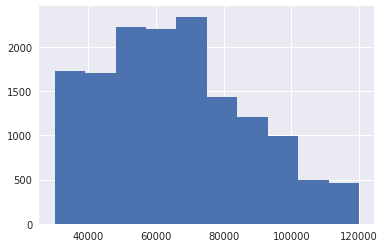

In [56]:
profile['income'].hist()

In [57]:
profile['income'].value_counts().head()

73000.0    314
72000.0    297
71000.0    294
57000.0    288
74000.0    282
Name: income, dtype: int64

In [58]:
# lets only look at the income of customers and how they received, viewed and completed the offers

df_income_offer_completed = df_only_offers[['income','offer_id','event_offer_completed','event_offer_received','event_offer_viewed']]
# lets breakup the ages into age groups as per the decades i.e. 40s, 50s , 60s etc.
df_income_offer_completed['income_range']= df_income_offer_completed['income'].apply(lambda x: int(x/10000)*10000)
df_income_offer_completed.head()

,income,offer_id,event_offer_completed,event_offer_received,event_offer_viewed,income_range
0,100000.0,3.0,0,1,0,100000
1,100000.0,3.0,0,0,1,100000
3,100000.0,3.0,1,0,0,100000
5,100000.0,7.0,0,1,0,100000
6,100000.0,7.0,0,0,1,100000


In [59]:
dff1 = df_income_offer_completed.groupby(['income_range','offer_id'],as_index=False)['event_offer_received','event_offer_viewed','event_offer_completed'].mean()
dff1.head()

,income_range,offer_id,event_offer_received,event_offer_viewed,event_offer_completed
0,30000,0.0,0.447077,0.427923,0.125000
1,30000,1.0,0.454403,0.430954,0.114643
2,30000,2.0,0.748518,0.251482,0.000000
3,30000,3.0,0.535093,0.206064,0.258843
4,30000,4.0,0.696359,0.110767,0.192874


In [60]:
# Credits stack overflow: https://stackoverflow.com/questions/45161355/pandas-dataframe-find-the-max-after-groupby-two-columns-and-get-counts

# we need to look at the offer ids for each group which had the highest mean value of offer completion
dff2 = dff1.groupby(['income_range']).apply(lambda x: x.offer_id[x.event_offer_completed.idxmax()])
# convert the series into a dataframe
dff2 = pd.DataFrame(dff2).reset_index()
# assign column name to the max completed offer
dff2.rename(columns = {0:'max_offer_id'}, inplace = True) 

dff2

,income_range,max_offer_id
0,30000,3.0
1,40000,3.0
2,50000,3.0
3,60000,3.0
4,70000,3.0
5,80000,4.0
6,90000,4.0
7,100000,4.0
8,110000,4.0
9,120000,3.0


In [61]:
# merge our max offer id dataframe with the portfolio to have a look at the details of each offer id
dff2.merge(portfolio,left_on='max_offer_id',right_on='offer_id')

,income_range,max_offer_id,difficulty,duration,reward,offer_id,email,social,mobile,web,offer_type_bogo,offer_type_discount,offer_type_informational
0,30000,3.0,5,7,5,3,1.0,0.0,1.0,1.0,1,0,0
1,40000,3.0,5,7,5,3,1.0,0.0,1.0,1.0,1,0,0
2,50000,3.0,5,7,5,3,1.0,0.0,1.0,1.0,1,0,0
3,60000,3.0,5,7,5,3,1.0,0.0,1.0,1.0,1,0,0
4,70000,3.0,5,7,5,3,1.0,0.0,1.0,1.0,1,0,0
5,120000,3.0,5,7,5,3,1.0,0.0,1.0,1.0,1,0,0
6,80000,4.0,20,10,5,4,1.0,0.0,0.0,1.0,0,1,0
7,90000,4.0,20,10,5,4,1.0,0.0,0.0,1.0,0,1,0
8,100000,4.0,20,10,5,4,1.0,0.0,0.0,1.0,0,1,0
9,110000,4.0,20,10,5,4,1.0,0.0,0.0,1.0,0,1,0


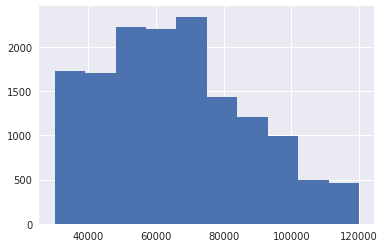

In [62]:
profile['income'].hist()

## Observations

The above analysis confirms the popularity of offer id 3 amongst low and middle income groups. Assuming that income groups are directly proportional to age ( in most of the cases) we can see that together, age and income, are quite a good indicator of which offers are preferred for a group and what offers can be recommended.

Based on the data we have the income range and corresponding offer_ids that have been completed by people in each income range

This tells us that
1. people in the income range of 30000 to 70000 (which is where a large number of customer profiles fall in the histogram above) preferred offer id 3 

Again as we concluded in the earlier section, one of the reasons for offer 3's popularity could be that their is a lower level of difficulty i.e. the amount that is needed to be spent to avail the offer, the reward is the maximum amongst all the available offers. 

And last but not the least one of the biggest takeaways is because its a BOGO( Buy one get one) offer which resonates with the group.

3. people in the higher income range have preferred offer 4, which can be seen to have a higher difficulty level i.e. a higher amount to be completed for the reward. We will look at similar offer recommendations next below

## Recommendations

In [63]:
# lets look at the similar offers for each income range
dff2['similar_offers'] = dff2['max_offer_id'].apply(lambda x: m.find_similar_offers(int(x),portfolio))
dff2

,income_range,max_offer_id,similar_offers
0,30000,3.0,8
1,40000,3.0,8
2,50000,3.0,8
3,60000,3.0,8
4,70000,3.0,8
5,80000,4.0,9
6,90000,4.0,9
7,100000,4.0,9
8,110000,4.0,9
9,120000,3.0,8


In [64]:
# This can be seen as both offer 3 and offer 8 are BOGO buy one get one offers and both have a difficulty of 5
portfolio.query("offer_id == 3 or offer_id==8")

,difficulty,duration,reward,offer_id,email,social,mobile,web,offer_type_bogo,offer_type_discount,offer_type_informational
3,5,7,5,3,1.0,0.0,1.0,1.0,1,0,0
8,5,5,5,8,1.0,1.0,1.0,1.0,1,0,0


In [65]:
portfolio.query("offer_id == 4 or offer_id==9")

,difficulty,duration,reward,offer_id,email,social,mobile,web,offer_type_bogo,offer_type_discount,offer_type_informational
4,20,10,5,4,1.0,0.0,0.0,1.0,0,1,0
9,10,7,2,9,1.0,0.0,1.0,1.0,0,1,0


### Insight 3 : Targeting/Recommending offers based on gender of the customer

We are now going to work on looking at the gender group of customers who "completed" an offer and "what" offer did they prefer amongst the ones in the portfolio data

In [66]:
# lets only look at the income of customers and how they received, viewed and completed the offers
df_gender_offer_completed = df_only_offers[['gender_F','gender_M','gender_O','offer_id','event_offer_completed','event_offer_received','event_offer_viewed']]

df_gender_offer_completed.head()

,gender_F,gender_M,gender_O,offer_id,event_offer_completed,event_offer_received,event_offer_viewed
0,1,0,0,3.0,0,1,0
1,1,0,0,3.0,0,0,1
3,1,0,0,3.0,1,0,0
5,1,0,0,7.0,0,1,0
6,1,0,0,7.0,0,0,1


In [67]:
# grouping the values by gender and offer_id over mean values of offer_received, viewed and completed
# the mean value allows us to store the average acceptance of an offer over how it has been viewed and completed
dff1 = df_gender_offer_completed.groupby(['gender_F','gender_M','gender_O','offer_id'],as_index=False)['event_offer_received','event_offer_viewed','event_offer_completed'].mean()
dff1.head()

,gender_F,gender_M,gender_O,offer_id,event_offer_received,event_offer_viewed,event_offer_completed
0,0,0,1,0.0,0.395745,0.353191,0.251064
1,0,0,1,1.0,0.382979,0.377660,0.239362
2,0,0,1,2.0,0.578313,0.421687,0.000000
3,0,0,1,3.0,0.402390,0.302789,0.294821
4,0,0,1,4.0,0.458333,0.250000,0.291667


In [68]:
# Credits stack overflow: https://stackoverflow.com/questions/45161355/pandas-dataframe-find-the-max-after-groupby-two-columns-and-get-counts

# we need to look at the offer ids for each group which had the highest mean value of offer completion
dff2 = dff1.groupby(['gender_F','gender_M','gender_O']).apply(lambda x: x.offer_id[x.event_offer_completed.idxmax()])
# convert the series into a dataframe
dff2 = pd.DataFrame(dff2).reset_index()
# assign column name to the max completed offer
dff2.rename(columns = {0:'max_offer_id'}, inplace = True) 

dff2

,gender_F,gender_M,gender_O,max_offer_id
0,0,0,1,3.0
1,0,1,0,3.0
2,1,0,0,3.0


In [69]:
# merge our max offer id dataframe with the portfolio to have a look at the details of each offer id
dff2.merge(portfolio,left_on='max_offer_id',right_on='offer_id')

,gender_F,gender_M,gender_O,max_offer_id,difficulty,duration,reward,offer_id,email,social,mobile,web,offer_type_bogo,offer_type_discount,offer_type_informational
0,0,0,1,3.0,5,7,5,3,1.0,0.0,1.0,1.0,1,0,0
1,0,1,0,3.0,5,7,5,3,1.0,0.0,1.0,1.0,1,0,0
2,1,0,0,3.0,5,7,5,3,1.0,0.0,1.0,1.0,1,0,0


Observation : Offer 3 is the most sort after offer for all genders, and a similar offer 8 can be recommended.

Recommendation :

However, as the offer id is same for all genders in our analysis, this does not help us de-identify the preferred offer ids between different gender groups.

### Insight 4 : Predicting whether a customer is going to complete an offer or not based on their transaction profile

In [70]:
df_only_offers['offer_id'].unique()

array([ 3.,  7.,  0.,  8.,  9.,  2.,  6.,  5.,  4.,  1.])

In [71]:
df_only_offers.columns

Index(['time', 'customer_id', 'txn_value', 'age', 'became_member_on', 'income',
       'gender_F', 'gender_M', 'gender_O', 'difficulty', 'duration', 'reward',
       'offer_id', 'email', 'social', 'mobile', 'web', 'offer_type_bogo',
       'offer_type_discount', 'offer_type_informational',
       'event_offer_completed', 'event_offer_received', 'event_offer_viewed',
       'event_transaction', 'txn_type_amount', 'txn_type_offer_id'],
      dtype='object')

In [72]:
# dropping columns that we wont need for modeling
df_only_offers_cleaned = df_only_offers.drop(['time','txn_value','became_member_on', 'txn_type_amount', 'txn_type_offer_id'],axis=1)
df_only_offers_cleaned.head()

,customer_id,age,income,gender_F,gender_M,gender_O,difficulty,duration,reward,offer_id,...,social,mobile,web,offer_type_bogo,offer_type_discount,offer_type_informational,event_offer_completed,event_offer_received,event_offer_viewed,event_transaction
0,3,75,100000.0,1,0,0,5.0,7.0,5.0,3.0,...,0.0,1.0,1.0,1.0,0.0,0.0,0,1,0,0
1,3,75,100000.0,1,0,0,5.0,7.0,5.0,3.0,...,0.0,1.0,1.0,1.0,0.0,0.0,0,0,1,0
3,3,75,100000.0,1,0,0,5.0,7.0,5.0,3.0,...,0.0,1.0,1.0,1.0,0.0,0.0,1,0,0,0
5,3,75,100000.0,1,0,0,0.0,3.0,0.0,7.0,...,1.0,1.0,0.0,0.0,0.0,1.0,0,1,0,0
6,3,75,100000.0,1,0,0,0.0,3.0,0.0,7.0,...,1.0,1.0,0.0,0.0,0.0,1.0,0,0,1,0


In [73]:
# for each sutomer id and offer id, I am considering the max value for each row
# this provides me with the required data on whether an offer has been recieved, viewed, completed or not
df_offers_grouped = df_only_offers_cleaned.groupby(['customer_id','offer_id']).max()

# reset index to re-populate column names for customer and offer id
df_offers_grouped = df_offers_grouped.reset_index()

df_offers_grouped.head()

,customer_id,offer_id,age,income,gender_F,gender_M,gender_O,difficulty,duration,reward,...,social,mobile,web,offer_type_bogo,offer_type_discount,offer_type_informational,event_offer_completed,event_offer_received,event_offer_viewed,event_transaction
0,1,2.0,55,112000.0,1,0,0,0.0,4.0,0.0,...,0.0,1.0,1.0,0.0,0.0,1.0,0,1,0,0
1,1,3.0,55,112000.0,1,0,0,5.0,7.0,5.0,...,0.0,1.0,1.0,1.0,0.0,0.0,1,1,0,0
2,3,0.0,75,100000.0,1,0,0,10.0,7.0,10.0,...,1.0,1.0,0.0,1.0,0.0,0.0,1,1,1,0
3,3,3.0,75,100000.0,1,0,0,5.0,7.0,5.0,...,0.0,1.0,1.0,1.0,0.0,0.0,1,1,1,0
4,3,7.0,75,100000.0,1,0,0,0.0,3.0,0.0,...,1.0,1.0,0.0,0.0,0.0,1.0,0,1,1,0


In [74]:
df_offers_grouped.columns

Index(['customer_id', 'offer_id', 'age', 'income', 'gender_F', 'gender_M',
       'gender_O', 'difficulty', 'duration', 'reward', 'email', 'social',
       'mobile', 'web', 'offer_type_bogo', 'offer_type_discount',
       'offer_type_informational', 'event_offer_completed',
       'event_offer_received', 'event_offer_viewed', 'event_transaction'],
      dtype='object')

In [75]:
# Reference : https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html

X = df_offers_grouped.drop('event_offer_completed',axis=1)
y = df_offers_grouped['event_offer_completed']

# Scaling feature values for columns to improve modelling and prediction
# Create a min max scaler object
scaler= MinMaxScaler()

#select features to be scaled
features= ['age','income','difficulty','duration','reward']

# replace scaled features in the original dataframe
X[features] = scaler.fit_transform(X[features])

# train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42)

In [76]:
# Credits https://towardsdatascience.com/a-beginners-guide-to-xgboost-87f5d4c30ed7
# Additional Ref: https://www.analyticsvidhya.com/blog/2018/09/an-end-to-end-guide-to-understand-the-math-behind-xgboost/

# Set parameter values for XGBoost model
D_train = xgb.DMatrix(X_train, label=y_train)
D_test = xgb.DMatrix(X_test, label=y_test)

param = {
    'eta': 0.3, 
    'max_depth': 3,  
    'objective': 'multi:softprob',  
    'num_class': 3} 

# The number of training iterations
steps = 20

# Create a xgb model with the above parameter values
model = xgb.train(param, D_train, steps)

In [77]:
# make predictions
preds = model.predict(D_test)

# find the best prediction values
best_preds = np.asarray([np.argmax(line) for line in preds])

# print precision, recall and accuracy
print("Precision = {}".format(precision_score(y_test, best_preds, average='macro')))
print("Recall = {}".format(recall_score(y_test, best_preds, average='macro')))
print("Accuracy = {}".format(accuracy_score(y_test, best_preds)))

Precision = 0.7803186830662312
Recall = 0.7685688388631879
Accuracy = 0.7700851089515302


In [78]:
# get the score for feature importance
model_feature_importances = model.get_score(importance_type='gain')

# sort the weight of each feature importance
sorted_feature_importances = sorted(model_feature_importances.items(), key=operator.itemgetter(1),reverse=True)
sorted_feature_importances

[('difficulty', 511.8818089202102),
 ('reward', 123.37855919999998),
 ('event_offer_viewed', 121.10423787476189),
 ('income', 114.04627208805553),
 ('offer_id', 97.11225076166666),
 ('gender_M', 87.53316461642858),
 ('duration', 13.125453755833334),
 ('gender_F', 12.9900513),
 ('age', 11.828742771666667)]

## Final Observations

Based on our analysis of the model above

1. The difficulty level of the offer, i.e. the minimum required spend needed to complete an offer is the highest factor contributing to the offer completion.

This in a way aligns with our understanding of how a difficulty level of 7 or 5 would be preferred over a difficulty level of 10 considering the majority of the population is distributed normally. A larger proportion of the portfolio falls between income groups of 50k to 90k and aged between 30 to 70. Individual recommendations for sections have been made in the notebook earlier.

2. The next factor is the reward value.

Higher the reward value, higher is the subscriber attraction to those offers

3. The third factor is if the offer has been viewed or not. 

The offer being viewed is one of the top most reasons for an offer getting completed. This asserts the importance of focusing marketing efforts to the right section of subscribers

4. Income

The income, as is expected, affects the offer completion based on which income group the subscriber falls into. Individual recommendations for income groups have been included in the earlier section above.

5. Gender

Gender makes it to our top 5 list of factors, although based on subscriber behaviour for both genders in this dataset, there isnt a large distinction that can be made. Overall both genders preferred the same offer id.


## Wrapping up and Improvements

A combination of age, income and gender of a subsriber is going to be the final decision point of recommending offers for a subscriber. This will allow Starbucks to provide concerted efforts for its marketing campaigns.

The model we have used for predicting offer completion can be improved upon based on better feature selection, removing highly collinear interaction terms and better model selection.